In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras.layers import AveragePooling2D, MaxPooling2D, Convolution2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras import Sequential

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19


In [2]:
main_directory = 'deepfake'
split_directory = 'deepfake_split'

os.makedirs(split_directory, exist_ok=True)
class_directories = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]

In [3]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [4]:
train_directory = os.path.join(split_directory, 'train')
validation_directory = os.path.join(split_directory, 'validation')
test_directory = os.path.join(split_directory, 'test')

os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

In [5]:
# Iterate through each class directory and move images to the appropriate split
for class_dir in class_directories:
    class_path = os.path.join(main_directory, class_dir)
    files = os.listdir(class_path)
    num_samples = len(files)
    
    num_train = int(train_ratio * num_samples)
    num_validation = int(validation_ratio * num_samples)
    
    train_samples = files[:num_train]
    validation_samples = files[num_train:num_train + num_validation]
    test_samples = files[num_train + num_validation:]
    
    for file in train_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)
    
    for file in validation_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(validation_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)
    
 
    for file in test_samples:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_directory, class_dir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)


In [5]:
input_shape = (64, 64, 3)
batch_size = 16

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    train_directory,  
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  
    shuffle=False  # Set to False to maintain class-wise order
)

# Get the class labels and their corresponding indices
class_indices = generator.class_indices
num_classes = len(class_indices.items())

for class_name, class_idx in class_indices.items():
    class_count = (generator.classes == class_idx).sum()
    print(f'Class {class_name}: {class_count} samples')


Found 107100 images belonging to 2 classes.
Class deepfake_resized: 105000 samples
Class untouched_resized: 2100 samples


Class deepfake_resized: 105000 samples


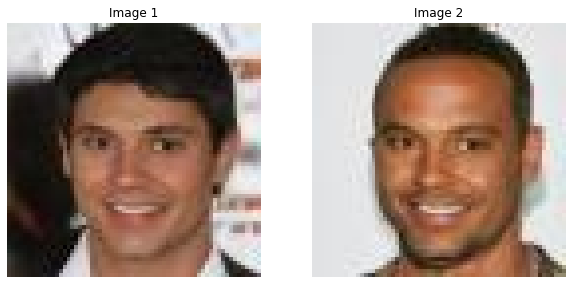

Class untouched_resized: 2100 samples


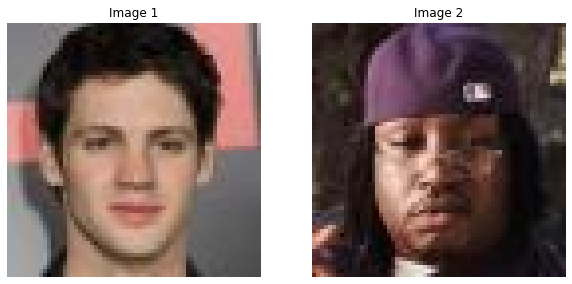

In [17]:
num_images_per_class = 2

for class_name, class_idx in class_indices.items():
    class_count = (generator.classes == class_idx).sum()

    if class_count > 0:
        print(f'Class {class_name}: {class_count} samples')
        plt.figure(figsize=(5, 5))

        # Retrieve the first num_images_per_class images from the generator
        images_to_display = []
        image_count = 0
        for image, label in generator:
            if label[0] == class_idx:
                images_to_display.append(image[0])
                image_count += 1
            if image_count >= num_images_per_class:
                break

        for i, img in enumerate(images_to_display):
            plt.subplot(1, num_images_per_class, i + 1)
            plt.imshow(img)
            plt.title(f'Image {i + 1}')
            plt.axis('off')

        plt.show()


In [7]:
num_samples_per_epoch = 100

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 107100 images belonging to 2 classes.
Found 22950 images belonging to 2 classes.
Found 22951 images belonging to 2 classes.


In [8]:
undersampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = undersampler.fit_resample(train_generator, train_generator.classes)
X_val_resampled, y_val_resampled = undersampler.fit_resample(validation_generator, validation_generator.classes)


MemoryError: Unable to allocate 768. KiB for an array with shape (16, 64, 64, 3) and data type float32

In [ ]:
# Calculate class weights for the balanced datasets
class_weights_train = compute_class_weight('balanced', np.unique(y_train_resampled), y_train_resampled)
class_weights_val = compute_class_weight('balanced', np.unique(y_val_resampled), y_val_resampled)

In [ ]:
epochs = 150
learning_rate=0.0001

adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate, momentum=0.9, nesterov=True)

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5) #change learning rATE  to get the best result

In [ ]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
#model.add(BatchNormalization()) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization()) 
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization()) 
model.add(MaxPooling2D((2, 2)))


# Flatten the feature maps
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_generator,
    steps_per_epoch=num_samples_per_epoch // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_samples_per_epoch // batch_size,
    callbacks=[model_checkpoint, early_stopping, lrr],
    class_weight=class_weights
)

In [ ]:
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=epochs,
    class_weight=class_weights_train,
    validation_data=(X_val_resampled, y_val_resampled, class_weights_val)
    callbacks=[model_checkpoint, early_stopping, lrr]
)

In [ ]:
from tensorflow import keras

loaded_model = keras.models.load_model('best_model.h5')

In [ ]:
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
y_pred = loaded_model.predict(test_generator)
y_true = test_generator.classes

# Generate a classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred.argmax(axis=1), target_names=target_names)
print("Classification Report:\n", classification_rep)

In [ ]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
f1_macro = f1_score(y_true, y_pred.argmax(axis=1), average='macro')
f1_weighted = f1_score(y_true, y_pred.argmax(axis=1), average='weighted')

print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")